<h1> Viral tweet predictor </h1>

Import required python packages

In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as metric
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Import dataset containing random tweets

In [2]:
all_tweets = pd.read_json("random_tweets.json", lines=True)

Add a column to the dataframe that distinguishes whether a tweet is "viral" or not based on if the retweet count is higher than the median retweet count in the dataset. <br>
I then extracted useful columns for each tweet that were hidden in the "user" dictionary for each tweet and replaced any true or false values with 1 and 0

In [27]:
all_tweets["is_viral"] = all_tweets["retweet_count"].apply(lambda tweet: 0 if tweet < np.median(all_tweets["retweet_count"]) else 1)
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis = 1)
all_tweets['follower_count'] = all_tweets.apply(lambda tweet: tweet['user']["followers_count"], axis = 1)
all_tweets['friends_count'] = all_tweets.apply(lambda tweet: tweet['user']["friends_count"], axis = 1)
all_tweets['truncated'] = all_tweets["truncated"].replace([False, True], [0, 1])
all_tweets['verified'] = all_tweets.apply(lambda tweet: tweet['user']["verified"], axis = 1)
all_tweets['is_translation_enabled'] = all_tweets.apply(lambda tweet: tweet['user']["is_translation_enabled"], axis = 1)
all_tweets['is_translation_enabled'] = all_tweets["is_translation_enabled"].replace([False, True], [0, 1])
all_tweets['profile_use_background_image'] = all_tweets.apply(lambda tweet: tweet['user']["profile_use_background_image"], axis = 1)
all_tweets['profile_use_background_image'] = all_tweets["profile_use_background_image"].replace([False, True], [0, 1])
all_tweets['default_profile_image'] = all_tweets.apply(lambda tweet: tweet['user']["default_profile_image"], axis = 1)
all_tweets['default_profile_image'] = all_tweets["default_profile_image"].replace([False, True], [0, 1])

I created a series containing tweet labels depending on if they were viral or not, I also created a dataframe of all the features I may use for predictive purposes. This dataframe was then scaled to make sure each feature had equal weighting.

In [28]:
labels = all_tweets["is_viral"]
data = all_tweets[['tweet_length','follower_count','friends_count','truncated',"verified",'is_translation_enabled','profile_use_background_image','default_profile_image']]
scaled_data = scale(data,axis = 0)

Split the data into test and train subsets with a ratio of 1:5, then found the change in KNeighborsClassifier score as the number of n neighbours changed.

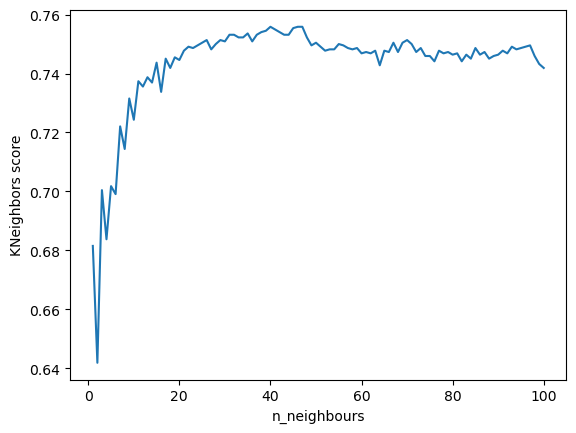

In [74]:
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2, random_state = 42)
scores = []
mean_absolute_errors = []
for k in range(1,101,1):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data,train_labels)
    scores.append(classifier.score(test_data, test_labels))
    y_predict = classifier.predict(test_data)
    mean_absolute_errors.append(mean_absolute_error(test_labels, y_predict))
plt.plot(range(1,101,1) , scores),
plt.xlabel("n_neighbours")
plt.ylabel("KNeighbors score")
plt.show()

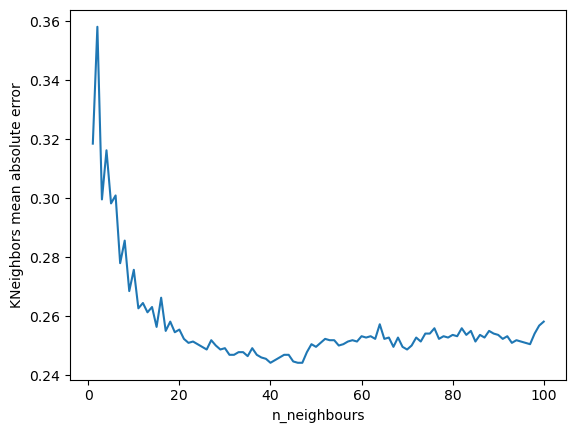

In [ ]:
plt.plot(range(1,101,1) , mean_absolute_errors),
plt.xlabel("n_neighbours")
plt.ylabel("KNeighbors mean absolute error")
plt.show()

The optimal number of neighbours seems to be around 30 so I will use this number to create the actual model

In [178]:
classifier = KNeighborsClassifier(n_neighbors = 30)
classifier.fit(train_data,train_labels)
y_predict = classifier.predict(test_data)
print("The model's accuracy score is: {}".format(round(classifier.score(test_data,test_labels),3)))
print("The model's recall score is: {}".format(round(metric.recall_score(test_labels,y_predict),3)))
print("The model's precision score is: {}".format(round(metric.precision_score(test_labels,y_predict),3)))

The model's accuracy score is: 0.751
The model's recall score is: 0.811
The model's precision score is: 0.734


As there are 2 possible outcomes, the accuracy score sans model would be expected to be 0.5 so the score obtained of 0.751 is statistically significant. I then produced a plot to show how many correct guesses, false virals and false non_virals were predicted in the testing dataset

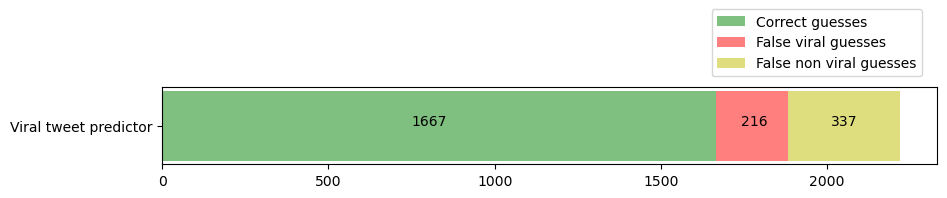

In [179]:
prediction_matrix = list(zip(test_labels,y_predict))
correct_guesses = 0
false_viral = 0
false_non_viral = 0 
for i in prediction_matrix:
    if i[0] == i[1]: correct_guesses += 1
    elif i[0] == 1 and i[1] == 0: false_viral += 1
    elif i[0] == 0 and i[1] == 1: false_non_viral += 1
    
x = ['Viral tweet predictor']
y1 = np.array([correct_guesses])
y2 = np.array([false_viral])
y3 = np.array([false_non_viral])
 
# plot bars in stack manner
plt.figure(figsize = [10,1])
plt.barh(x, y1, color='g',alpha=0.5).set_label('Correct guesses')
plt.barh(x, y2, left=y1, color='r',alpha=0.5).set_label('False viral guesses')
plt.barh(x, y3, left=(y1+y2) , color='y',alpha=0.5).set_label('False non viral guesses')
plt.text(750,0,str(correct_guesses))
plt.text(1740,0,str(false_viral))
plt.text(2010,0,str(false_non_viral))
plt.legend(bbox_to_anchor=(0.7, 1.05))
plt.show()